In [1]:
# importing necessary libraries and start a spark session
import numpy as np
import pandas as pd
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.246:7077") \
        .appName("mental_health_analysis")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.cores",2)\
        .config("spark.driver.port",9999)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()

spark_context = spark_session.sparkContext
# just show errors
spark_context.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/07 23:45:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# read the dataset from hdfs
data = spark_session.read.json("hdfs://192.168.2.142:9000/user/ubuntu/data/corpus-webis-tldr-17.json")
# print schema
# data.printSchema()

In [3]:
# show the first 10 rows
# data.show(10)

In [4]:
# convert spark dataframe to Pandas dataframe to show the dataset in a better format
# data_pandas = data.limit(10).toPandas()
# display(data_pandas)

In [5]:
# print total number of rows
# print("The number of total rows of the dataset is: \t", data.count())
# print the number of different subreddits
# print("The number of different subreddits is: \t", data.select("subreddit").distinct().count())

In [6]:
# take a subset of the data
subset_data = data.orderBy('id').limit(100000)
subset_data.show(10)

+-------------------+--------------------+--------------------+-----------+----+--------------------+-----------+------------+--------------------+-----------+-----+
|             author|                body|             content|content_len|  id|      normalizedBody|  subreddit|subreddit_id|             summary|summary_len|title|
+-------------------+--------------------+--------------------+-----------+----+--------------------+-----------+------------+--------------------+-----------+-----+
|     thebigbradwolf|I think starting ...|I think starting ...|         98|12bs|I think starting ...|programming|     t5_2fwo|Java is a difficu...|         14| NULL|
|       DarkSideofOZ|Back in 2002 I ha...|Back in 2002 I ha...|        396|21t9|Back in 2002 I ha...|  AskReddit|    t5_2qh1i|I had a wreck, ro...|         20| NULL|
|           GorillaJ|I don't think the...|I don't think the...|        375|29z0|I don't think the...|   politics|    t5_2cneq|you're a dumbass,...|         11| NULL|
|   

In [7]:
from pyspark.sql.functions import col

# defining keywords related to mental health, in tuple format
general_keywords = [
    'anxiety', 'panic', 'phobia', 
    'depression', 'bipolar', 'moodswings', 'mood_swings', 'mood swings',
    'schizophrenia', 'delusions', 'hallucinations',
    'anorexia', 'bulimia','binge_eating', 'addiction', 
    'obsessivecompulsivedisorder', 'obsessive_compulsive_disorder', 'obsessive compulsive disorder',
    'OCD', 'borderline', 'antisocial', 
    'narcissistic','PTSD', 'trauma', 'stress',
    'dissociative_identity', 'amnesia',
    'psychotic', 'depressive', 'suicide', 'suicidal'
]

# mental_disorders = [
#     'anxiety', 'panic', 'phobia', 
#     'depression', 'bipolar', 'mood swings',
#     'schizophrenia', 'delusions', 'hallucinations',
#     'anorexia', 'bulimia', 'binge eating','addiction', 
#     'obsessive compulsive disorder', 'OCD', 'borderline personality', 'antisocial', 
#     'narcissistic','PTSD', 'trauma', 'stress',
#     'dissociative identity', 'dissociative_identity', 'amnesia',
#     'psychotic', 'depressive', 'suicide', 'suicidal'
#     'mentalhealth', 'mental_health',
# ]


In [8]:
from pyspark.sql.functions import lower, trim

# preprocess subreddit column
subset_data = subset_data.withColumn('subreddit', lower(trim(col('subreddit'))))

# Create a DataFrame from the list of general keywords
keywords_df = spark_session.createDataFrame([(k,) for k in general_keywords], ['keyword'])

# Make sure that the keywords are lowercased
keywords_df = keywords_df.withColumn('keyword', lower(col('keyword')))

# Count the occurrences of each subreddit keyword
# Ensure that the join condition is based on the normalized 'subreddit' column
keyword_counts_data = (
    subset_data
    .join(keywords_df, col('subreddit') == col('keyword'), 'right_outer')
    .groupBy('keyword')
    .count()
    .orderBy('count', ascending=False)
)

# Show the result
keyword_counts_data.show()

+--------------------+-----+
|             keyword|count|
+--------------------+-----+
|          depression|  103|
|          moodswings|    1|
|              phobia|    1|
|         mood_swings|    1|
|             bipolar|    1|
|               panic|    1|
|             anxiety|    1|
|obsessive compuls...|    1|
|          antisocial|    1|
|          borderline|    1|
|obsessivecompulsi...|    1|
|           addiction|    1|
|                 ocd|    1|
|obsessive_compuls...|    1|
|             bulimia|    1|
|            anorexia|    1|
|      hallucinations|    1|
|           delusions|    1|
|         mood swings|    1|
|        binge_eating|    1|
+--------------------+-----+
only showing top 20 rows



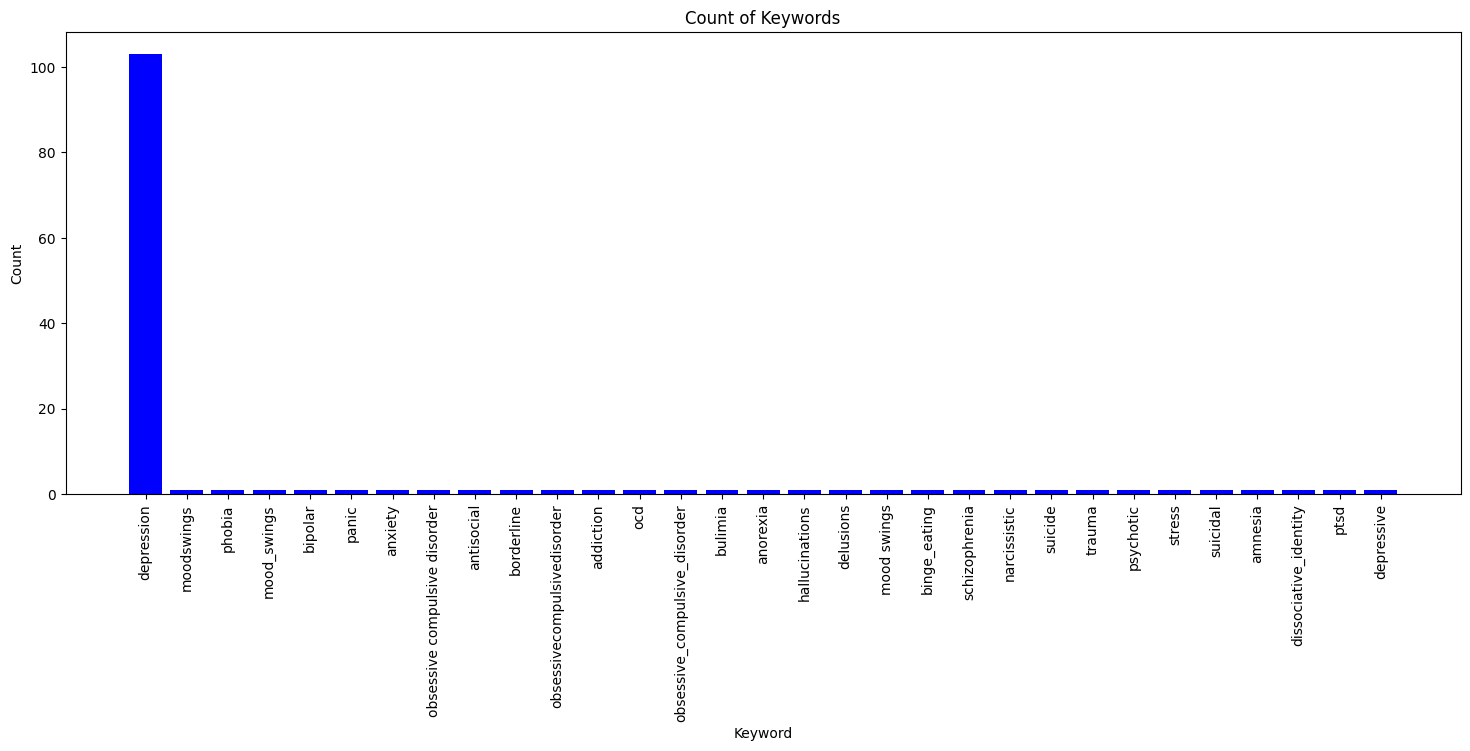

In [9]:
import matplotlib.pyplot as plt

# convert PySpark dataframe to pandas datafraame
keyword_counts_pandas = keyword_counts_data.toPandas()

plt.figure(figsize=(18, 6))
plt.bar(keyword_counts_pandas['keyword'], keyword_counts_pandas['count'], color='blue')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.title('Count of Keywords')
plt.xticks(rotation=90)
plt.show()

In [10]:
broadcasted_keywords = spark_session.sparkContext.broadcast(general_keywords)

def filter_keywords(content, keywords):
    return [keyword for keyword in keywords if keyword in content]

# Register the UDF with Spark
filter_keywords_udf = udf(lambda content: filter_keywords(content, broadcasted_keywords.value), ArrayType(StringType()))

# Apply the UDF to create the keywords_present column
subset_data = subset_data.withColumn("keywords_present", filter_keywords_udf(col('content')))

# Explode the keywords_present array into a new row for each keyword present per content
subset_data = subset_data.withColumn("keyword", explode("keywords_present"))

# Count the occurrences of each keyword
keyword_counts_df = subset_data.groupBy('keyword').count()

# Show the results
keyword_counts_df.show(truncate=False)

+--------------+-----+
|keyword       |count|
+--------------+-----+
|stress        |1381 |
|trauma        |348  |
|anxiety       |491  |
|depression    |733  |
|suicide       |537  |
|borderline    |118  |
|hallucinations|80   |
|addiction     |281  |
|narcissistic  |33   |
|panic         |894  |
|phobia        |176  |
|schizophrenia |83   |
|depressive    |59   |
|suicidal      |155  |
|OCD           |76   |
|PTSD          |65   |
|psychotic     |115  |
|antisocial    |30   |
|bipolar       |101  |
|moodswings    |1    |
+--------------+-----+
only showing top 20 rows



In [ ]:
# Sort the DataFrame by count in descending order
keyword_counts_df = keyword_counts_df.orderBy(col('count').desc())

# Collect the data to the driver node
keyword_counts_data = keyword_counts_df.collect()

keywords = [row['keyword'] for row in keyword_counts_data]
counts = [row['count'] for row in keyword_counts_data]

# Use matplotlib to plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.barh(keywords[::-1], counts[::-1])  # Reverse the lists to have the largest count at the top
plt.xlabel('Counts')
plt.ylabel('Keywords')
plt.title('Keyword Occurrences')
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlapping
plt.show()